In [1]:
import os
os.chdir("/workspace")


import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import confseq
from confseq import predmix, conjmix_bounded, betting
import algorithm
from algorithm import ConfSeq, Hypothesis


In [2]:
def standardise(x):
    return (x - x.min()) / (x.max() - x.min())

In [3]:
class HoffConf(algorithm.ConfSeq):
    def __init__(self, conf_lvl: float):
        super().__init__(conf_lvl)
    
    def calculate_cs(self, x):
        min_val, max_val =  x.min(), x.max()
        normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = predmix.predmix_hoeffding_cs(normalized, self.conf_lvl)

        lower_cs = lower_cs * (max_val - min_val) + min_val
        higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    
    @staticmethod
    def standardise(x):
        return (x - x.min()) / (x.max() - x.min())
    

class EmpbernConf(algorithm.ConfSeq):
    def __init__(self, conf_lvl: float):
        super().__init__(conf_lvl)
    
    def calculate_cs(self, x):
        min_val, max_val =  x.min(), x.max()
        normalized = (x - min_val) / (max_val - min_val)
        # self._risk_seq = normalized
        lower_cs, higher_cs = predmix.predmix_empbern_twosided_cs(normalized, self.conf_lvl, running_intersection=False)

        lower_cs = lower_cs * (max_val - min_val) + min_val
        higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    

class EmpbernConjmix(algorithm.ConfSeq):
    def __init__(self, conf_lvl: float):
        super().__init__(conf_lvl)
    
    def calculate_cs(self, x):
        min_val, max_val =  x.min(), x.max()
        normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = conjmix_bounded.conjmix_empbern_twosided_cs(normalized, 1/12, self.conf_lvl)

        lower_cs = lower_cs * (max_val - min_val) + min_val
        higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs

class EmpbernBetting(algorithm.ConfSeq):
    def __init__(self, conf_lvl: float):
        super().__init__(conf_lvl)
    
    def calculate_cs(self, x):
        min_val, max_val =  x.min(), x.max()
        normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = betting.betting_cs(normalized, self.conf_lvl)

        lower_cs = lower_cs * (max_val - min_val) + min_val
        higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs

In [4]:
class H0(Hypothesis):
    def __init__(self, tolerance:float, lower_bound:ConfSeq, upper_bound:ConfSeq):
        super().__init__(tolerance, lower_bound, upper_bound)
    
    @property
    def source_upper(self):
        return self.source_upper_cs[-1] + self.tolerance
    
    @property
    def target_lower(self):
        return self.target_lower_cs


        

In [16]:
np.random.seed(0)
N = 100000
data = np.random.normal(2, 3, N)
# data = np.random.uniform(0.4, 0.5, N)
# data = np.random.

print(f"data statistics: mean={np.mean(data)}, std={np.std(data)}")
print(f"min={np.min(data)}, median={np.median(data)}, max={np.max(data)}")

min_val = np.min(data)
max_val = np.max(data)


lower_ci, higher_ci = predmix.predmix_hoeffding_cs(x=standardise(data))

lower_ci = lower_ci * (max_val - min_val) + min_val
higher_ci = higher_ci * (max_val - min_val) + min_val

# print(f"lower_ci={lower_ci}")
# print(f"higher_ci={higher_ci}")



data statistics: mean=2.004730101524376, std=2.992019063482145
min=-12.556352959540352, median=2.005160666256744, max=14.725315738711089


In [23]:
source_bound = HoffConf(0.05)
target_bound = EmpbernConf(0.15)

source_data = np.random.normal(2, 3, 2000)

hyp = H0(tolerance=0.1, lower_bound=source_bound, upper_bound=target_bound)
hyp.calc_source_upper_cs(source_data)
hyp.test(data)

True

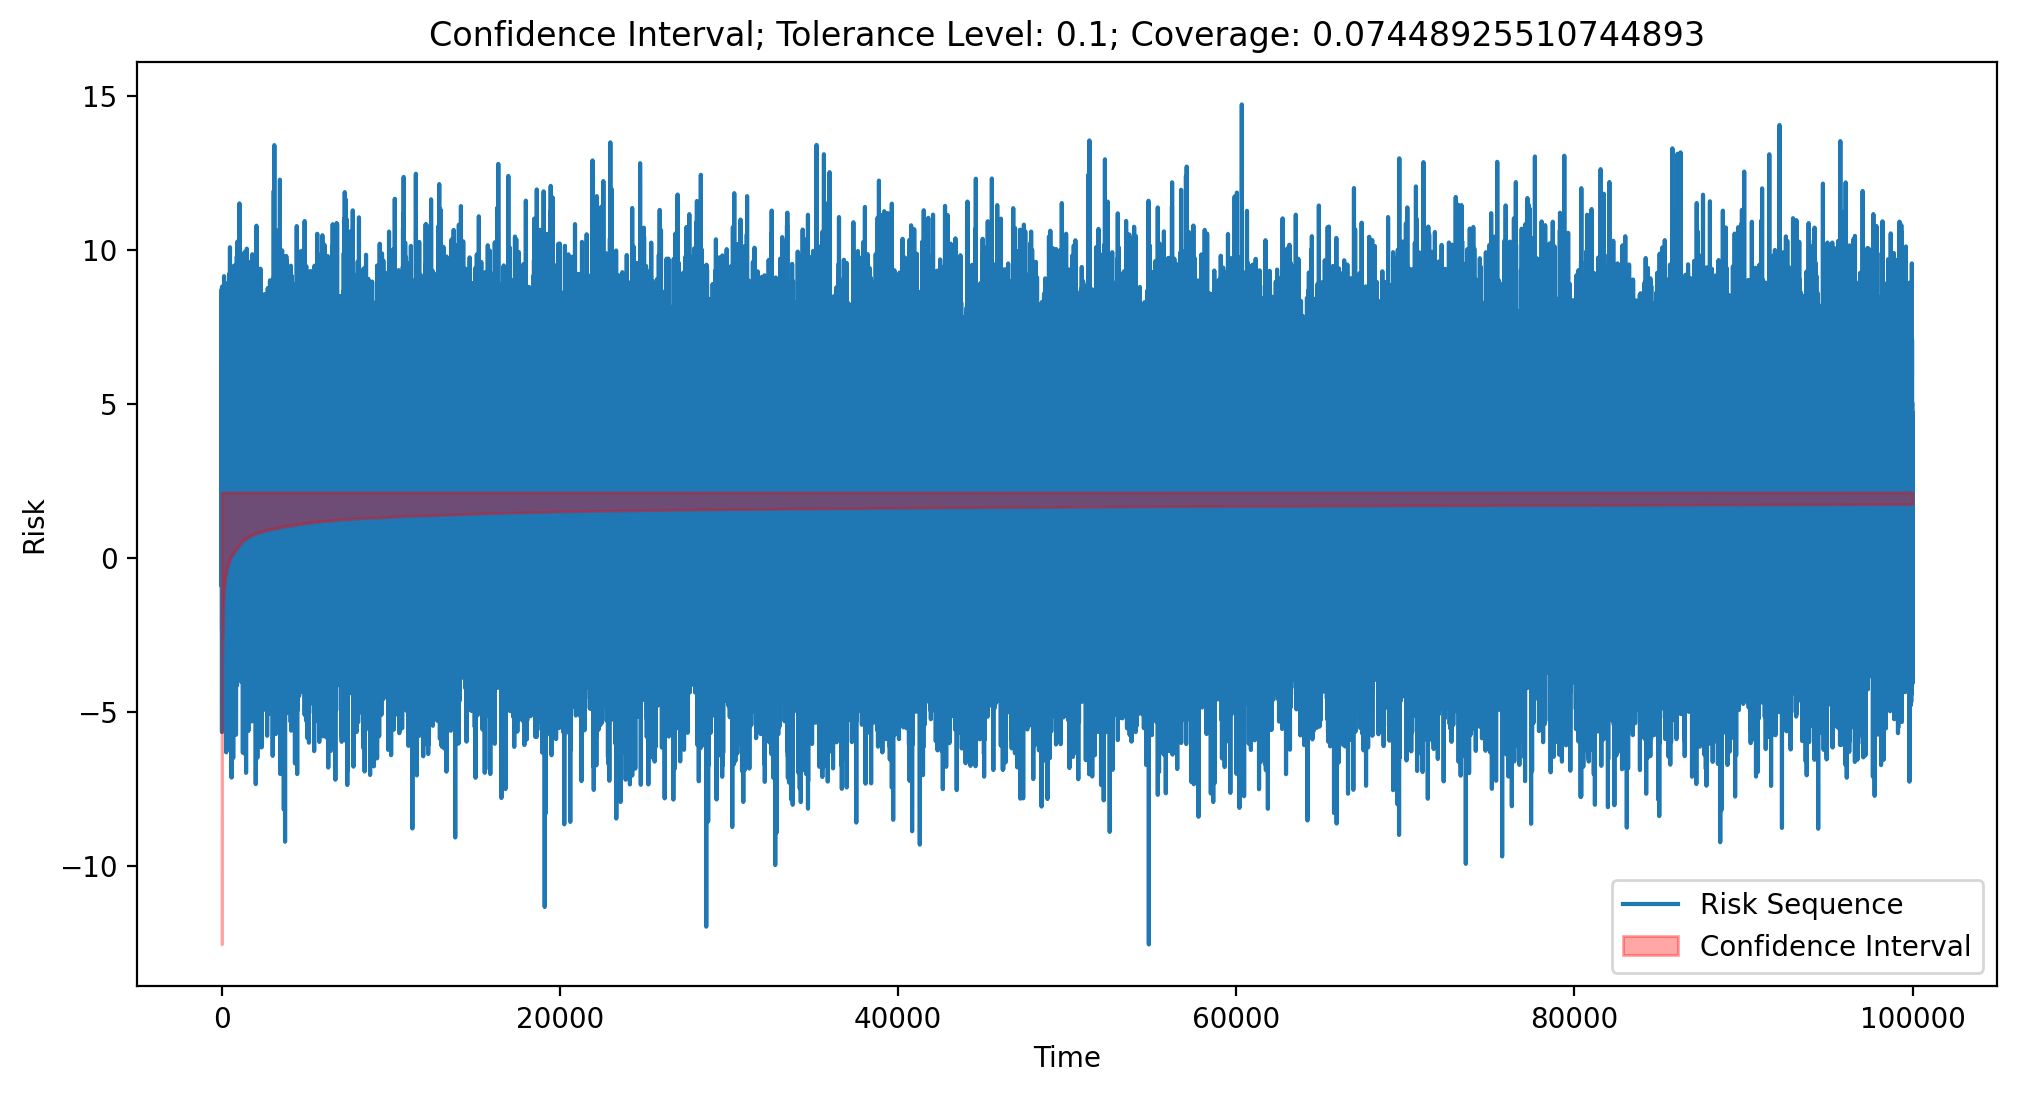

In [24]:
hyp.plot()

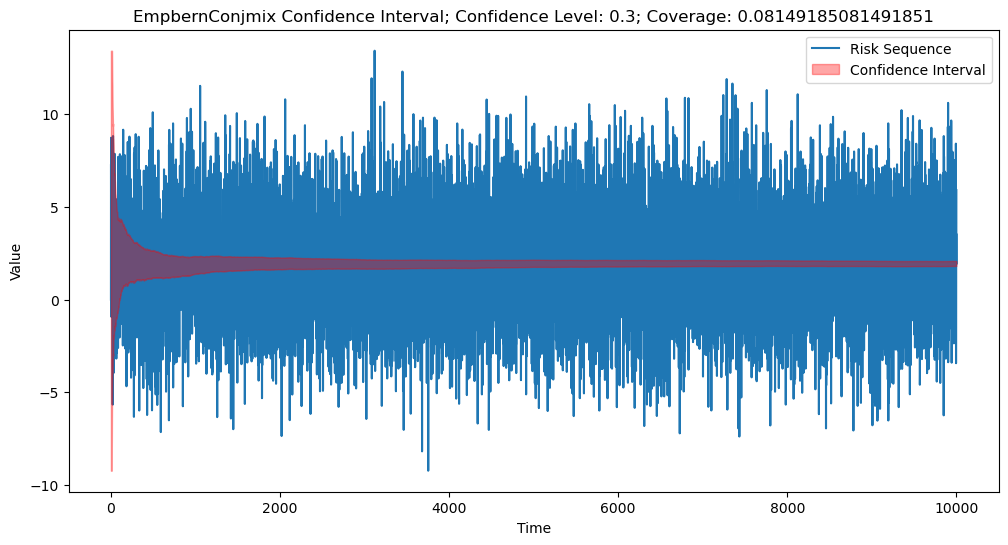

In [74]:
conf_seq = EmpbernConf(conf_lvl=0.3)
conf_seq = EmpbernConjmix(conf_lvl=0.3)
cs = conf_seq.update(data)
conf_seq.plot()

# hoff_cs.update(data)
# hoff_cs.plot()

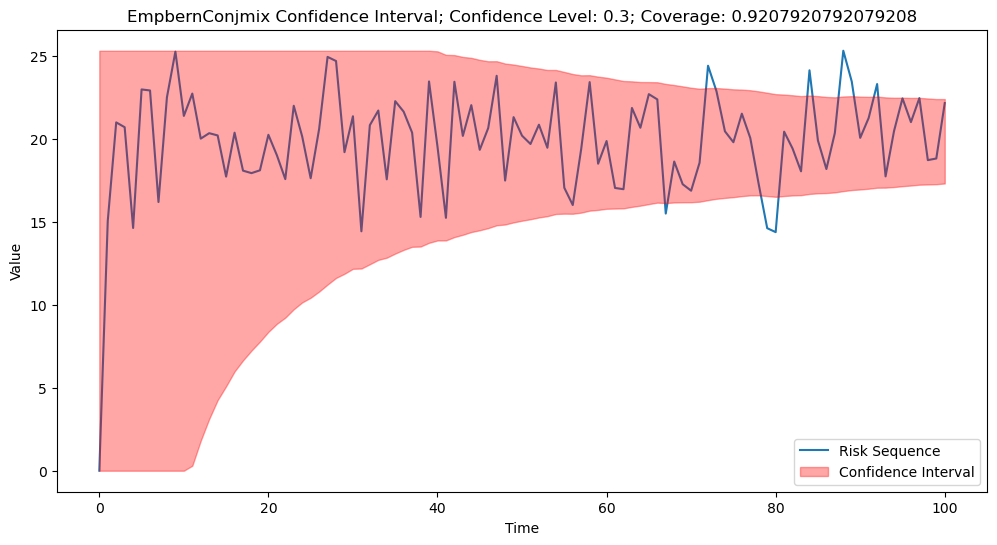

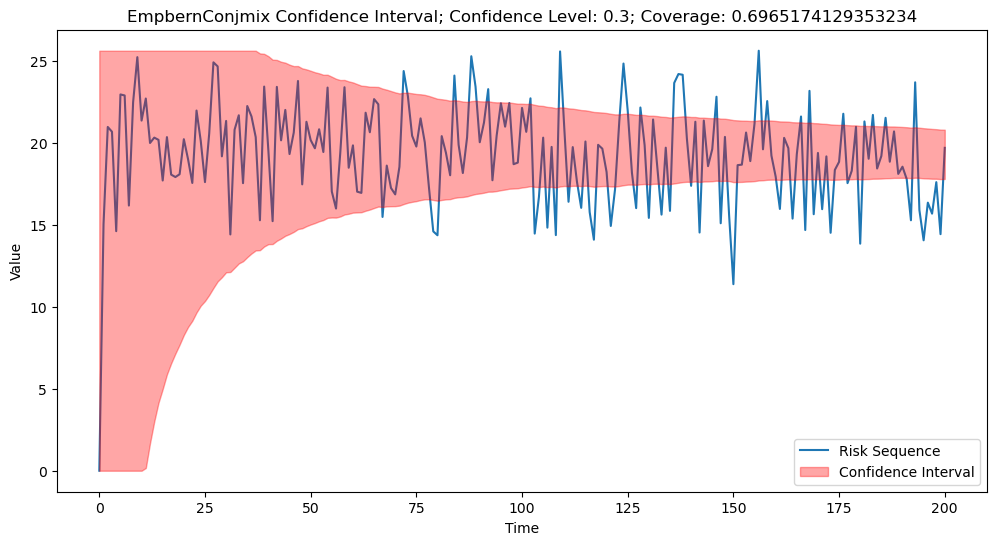

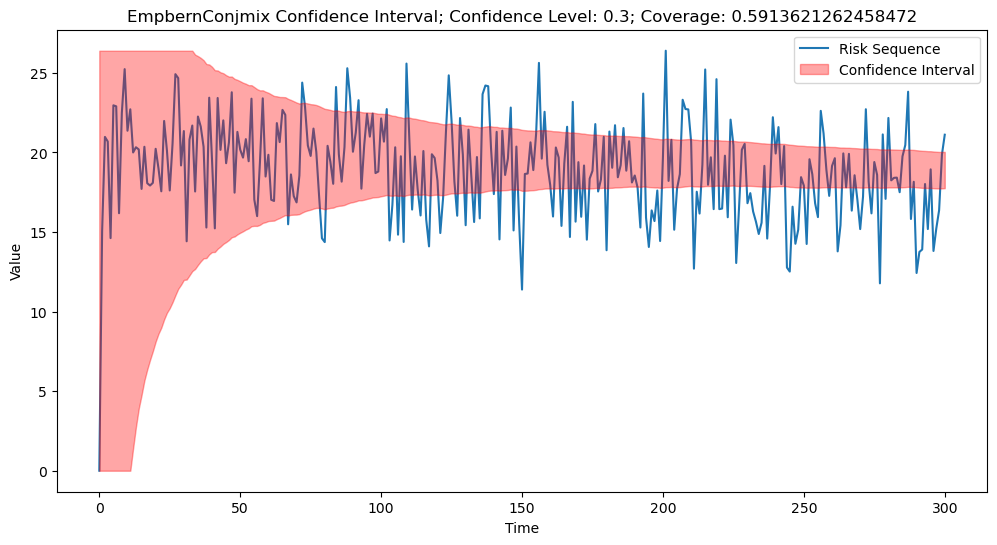

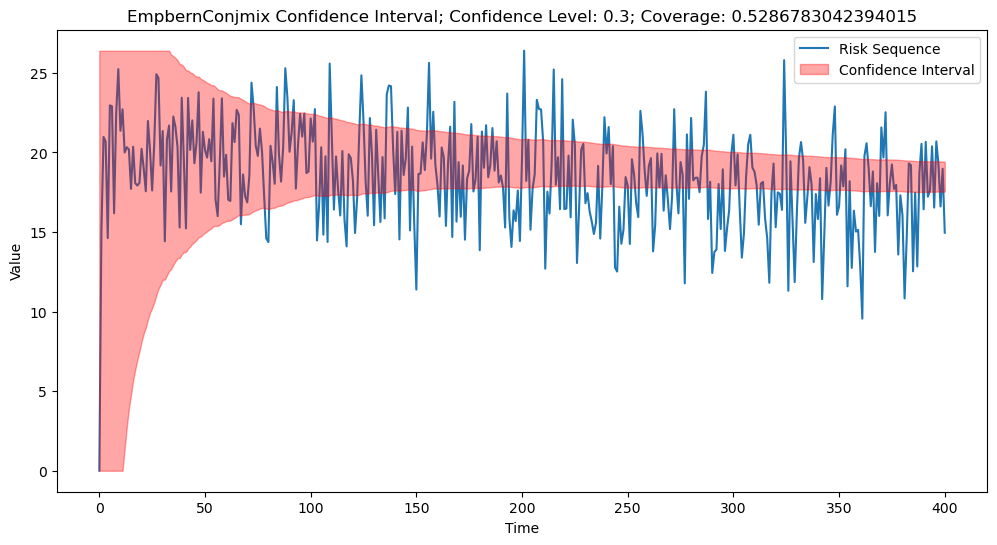

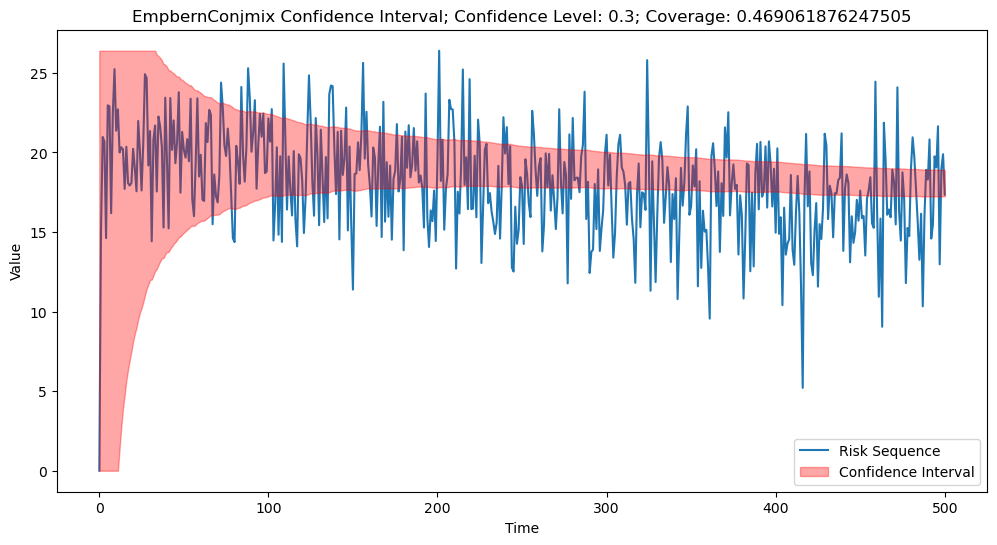

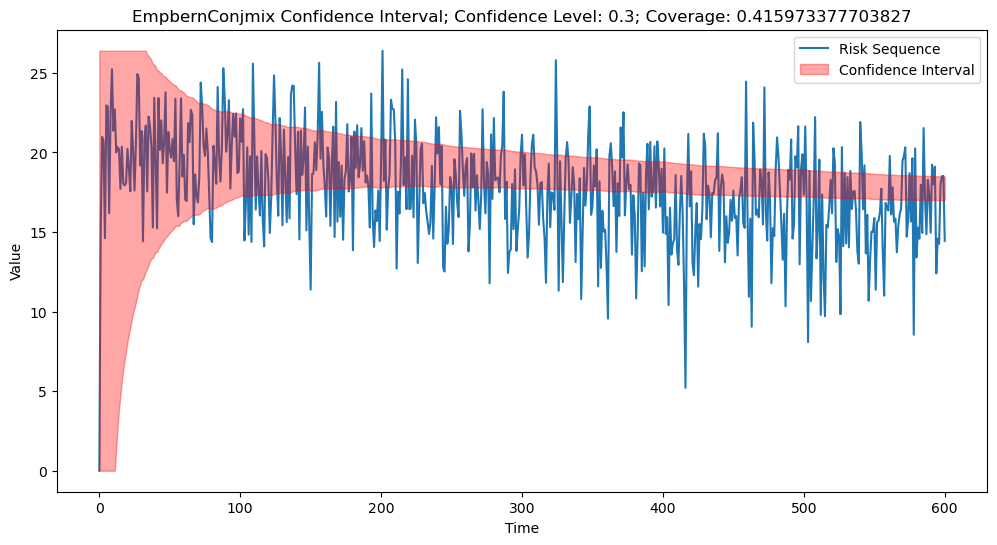

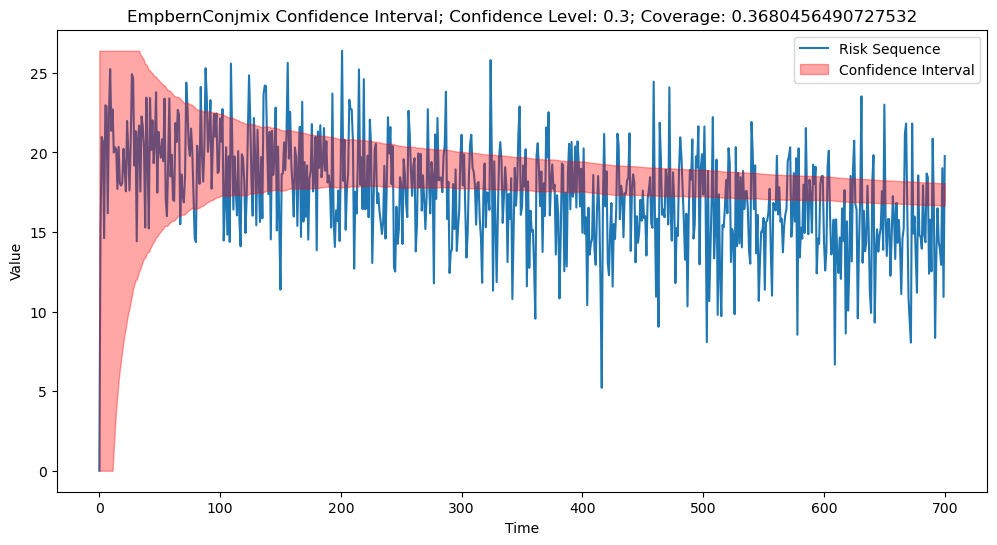

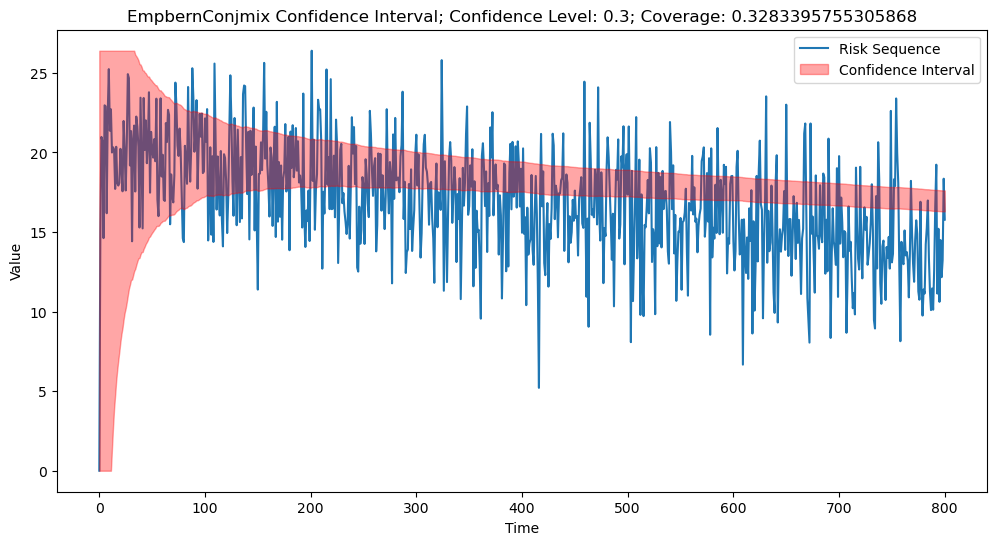

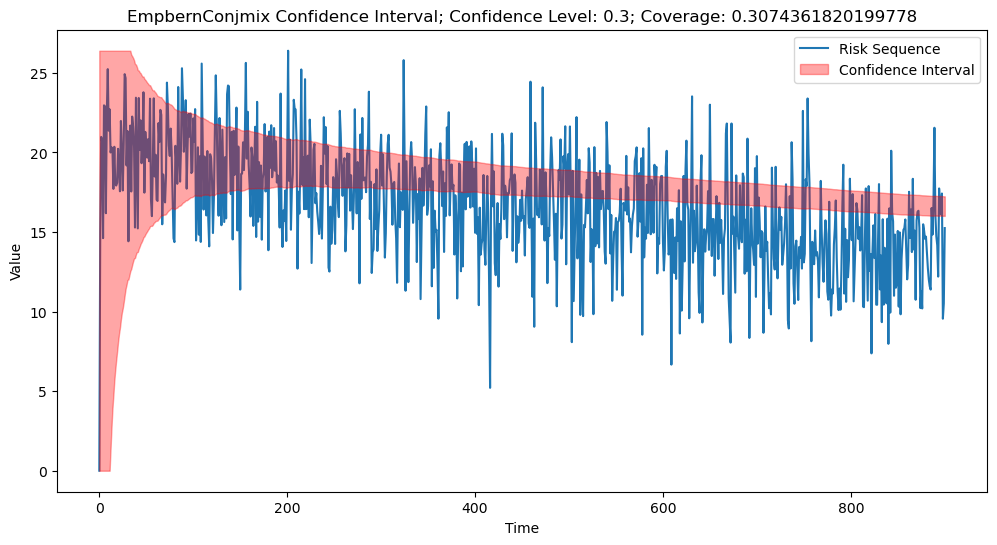

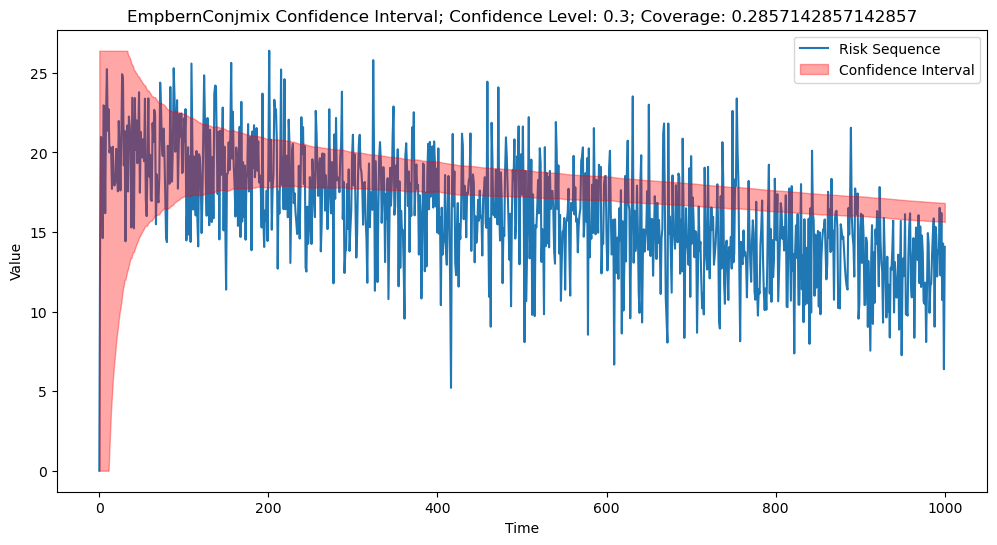

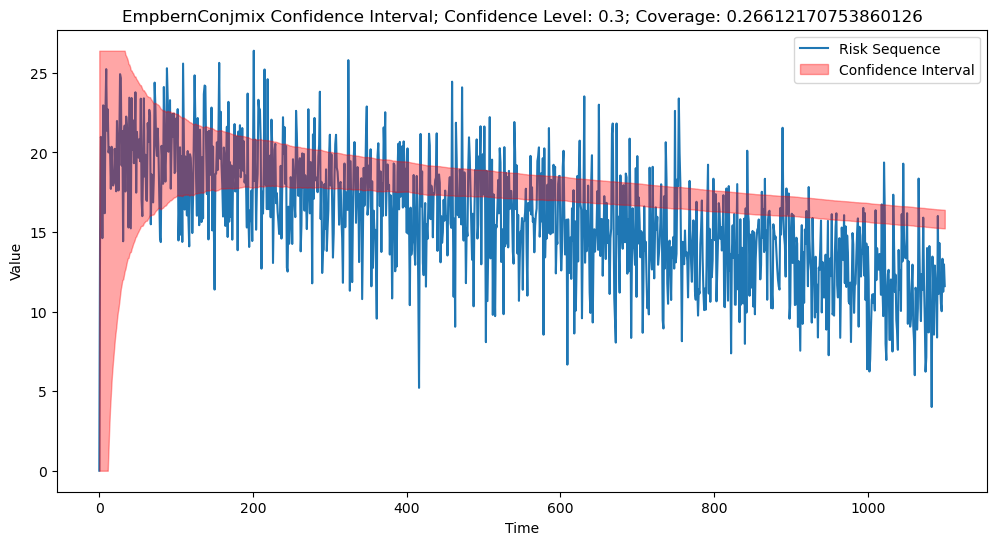

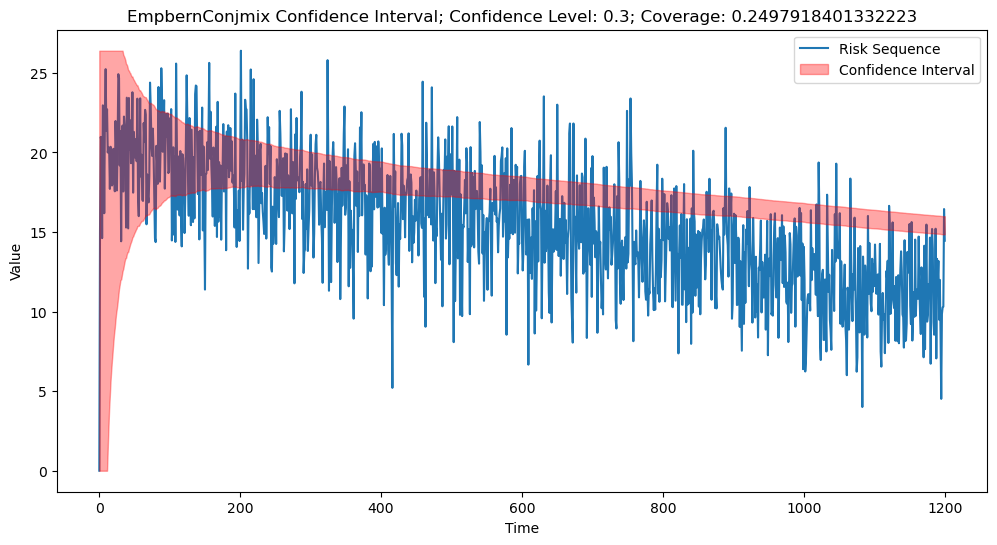

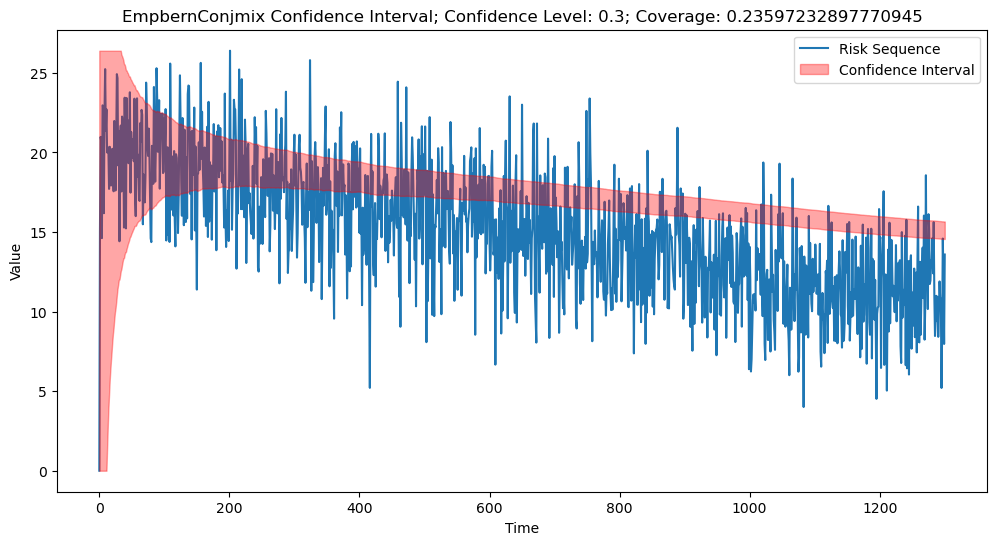

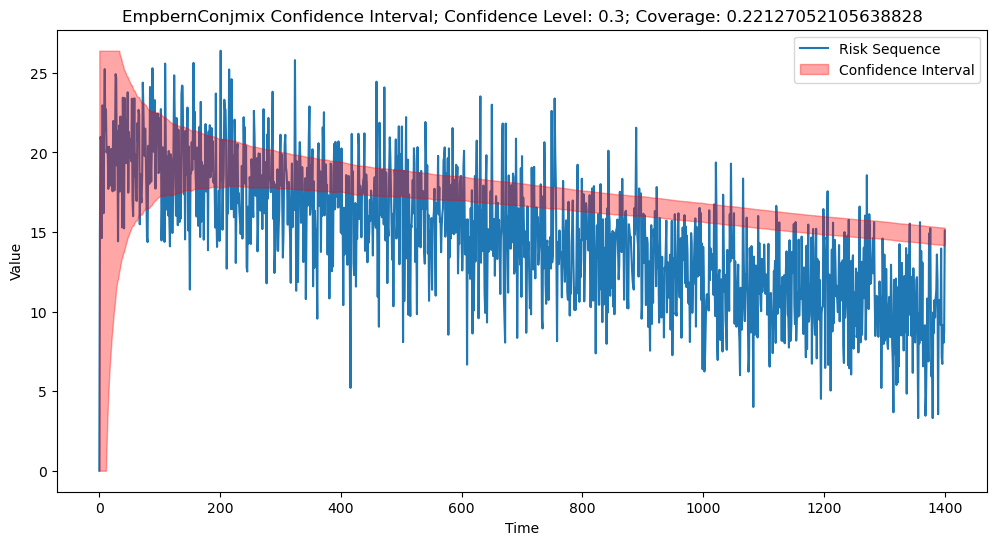

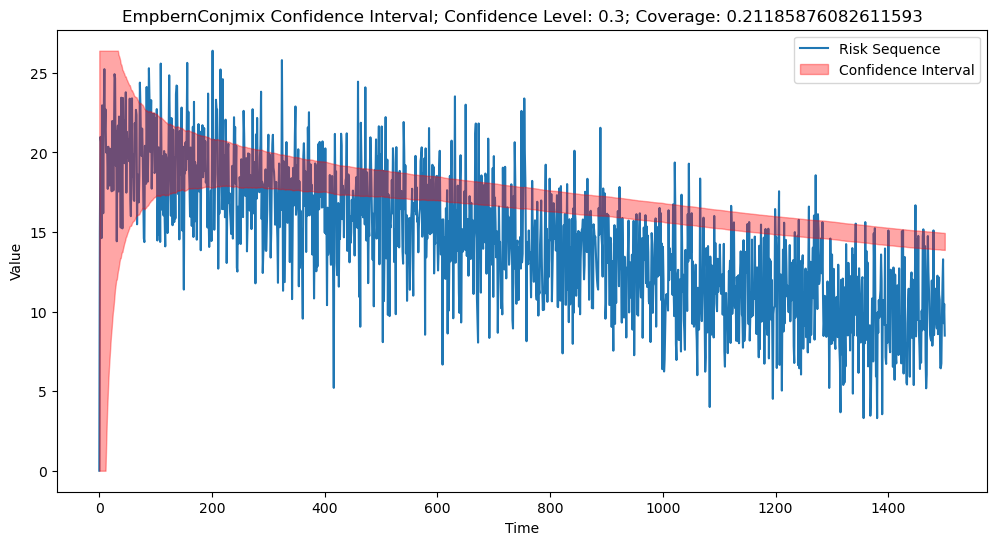

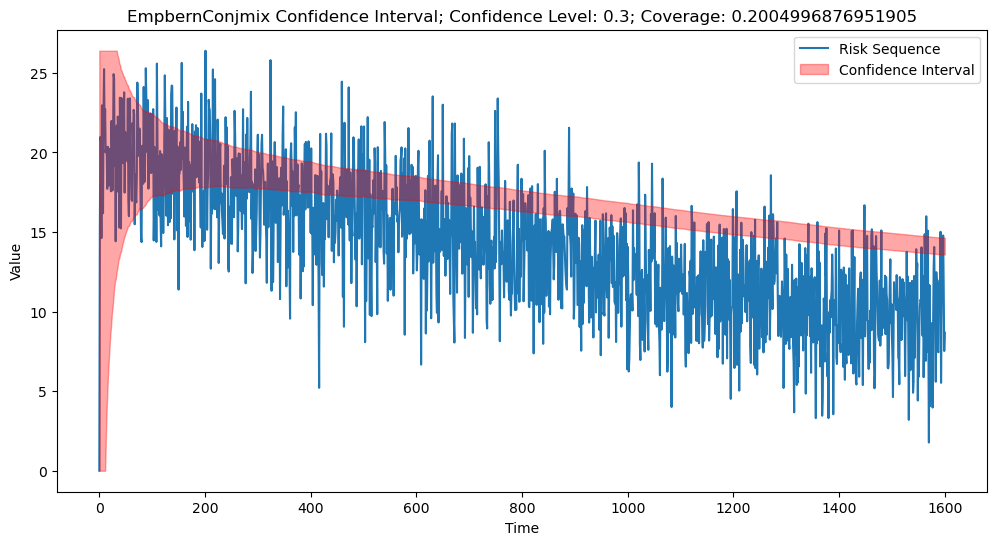

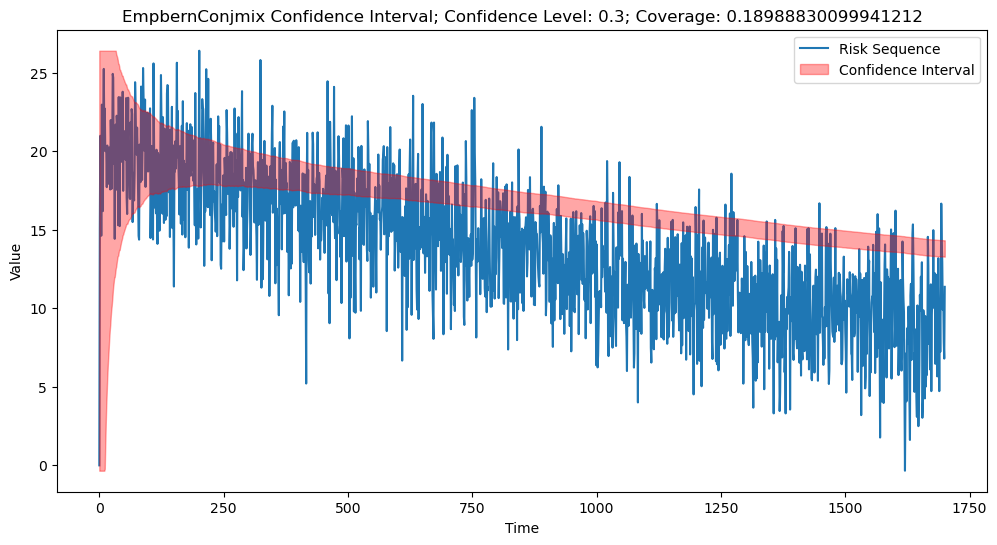

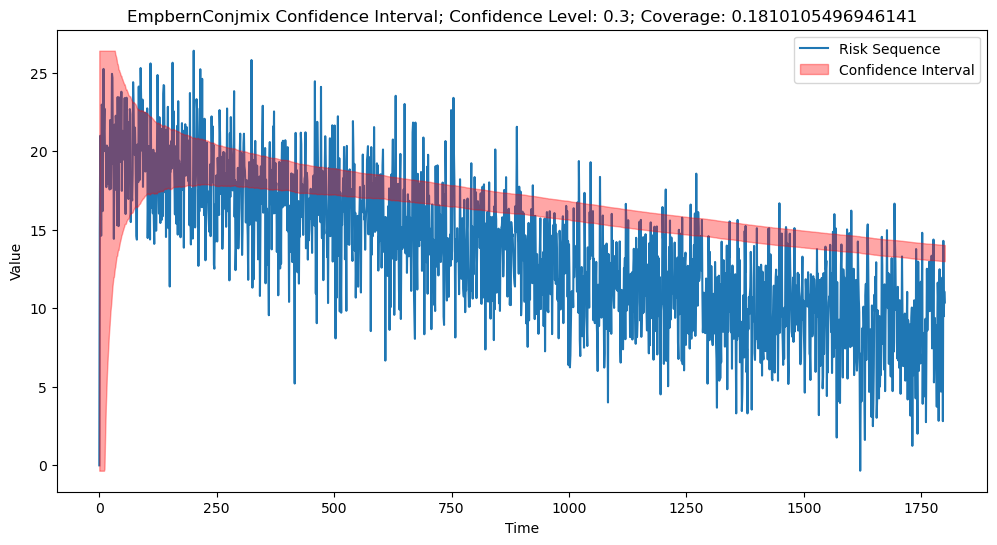

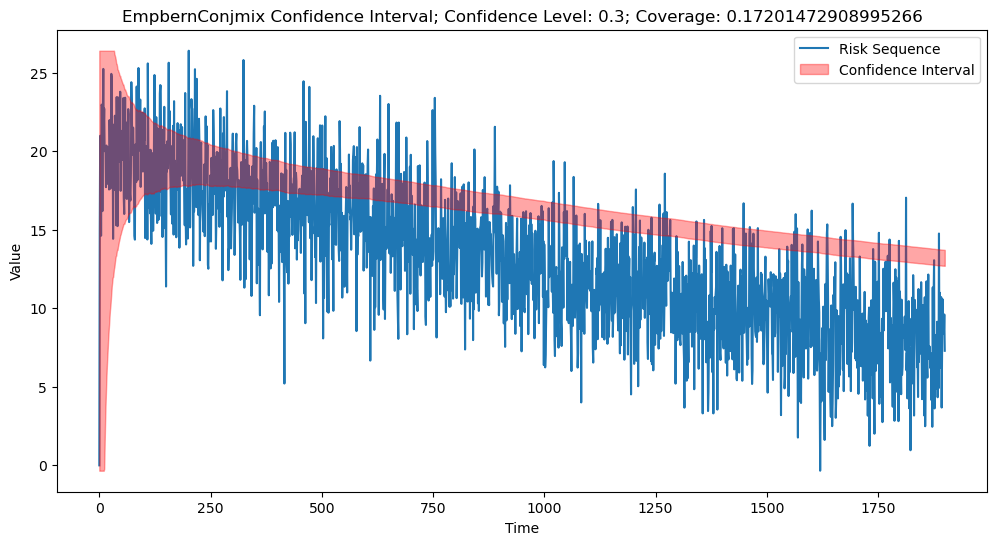

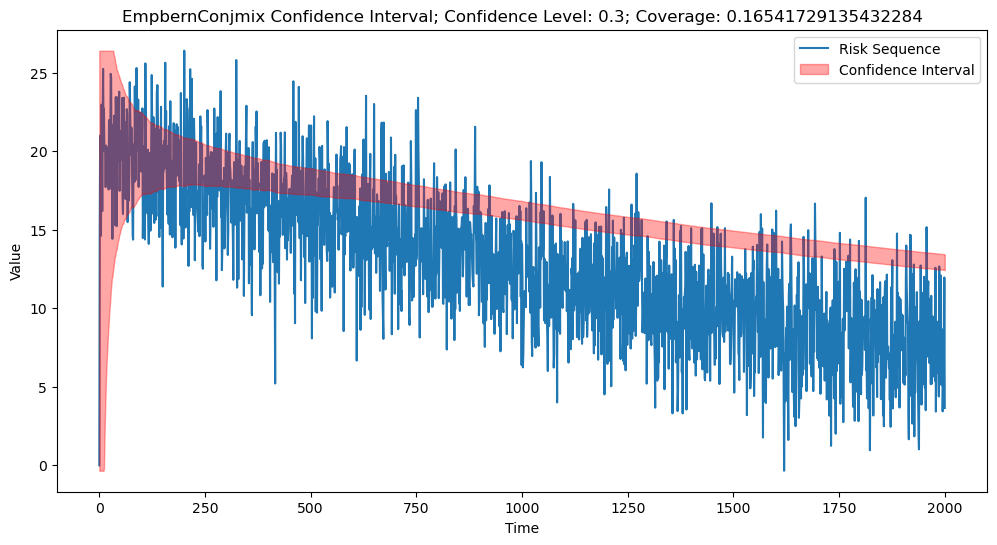

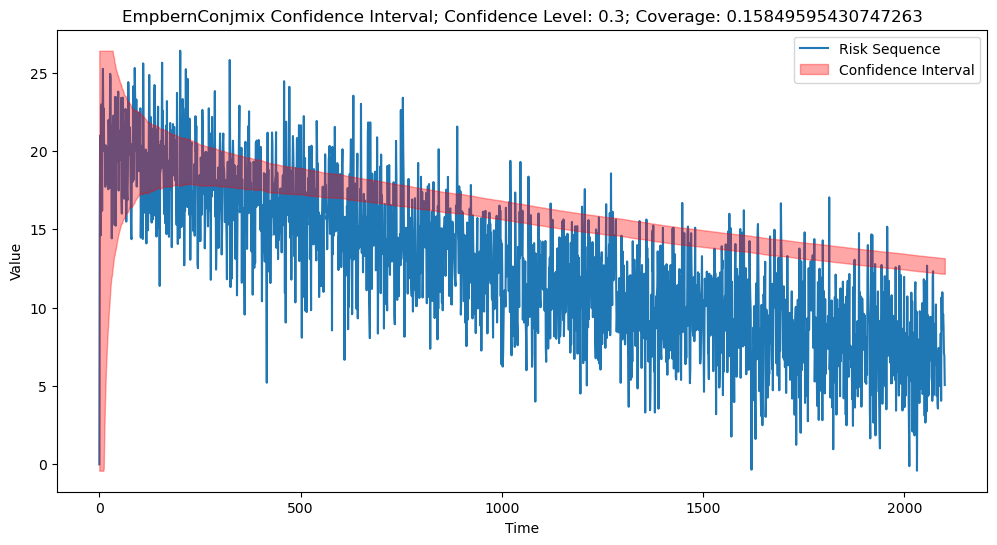

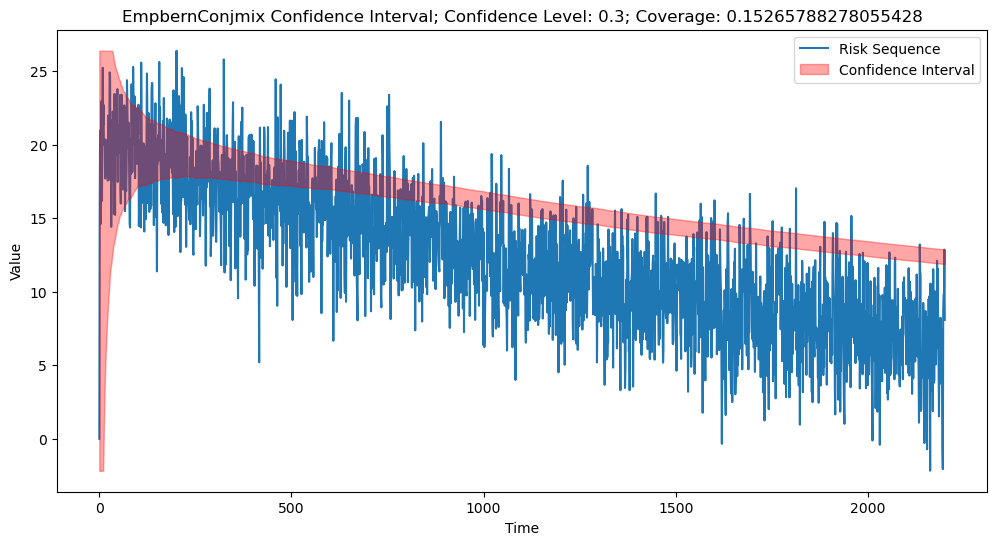

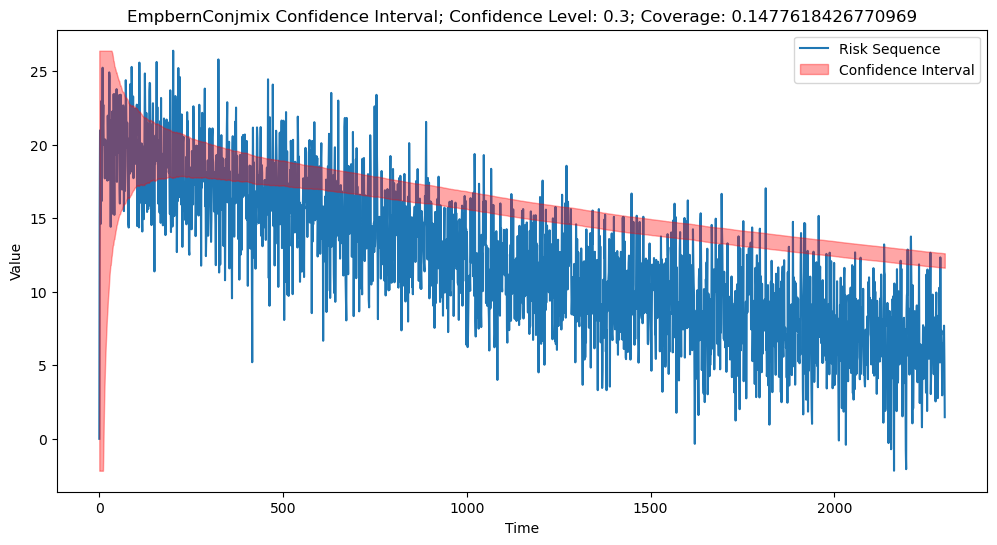

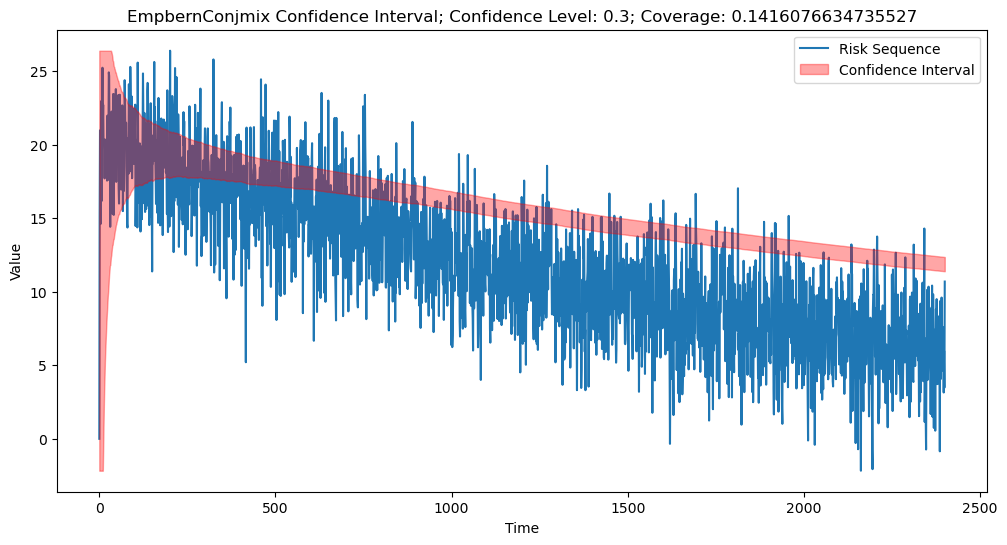

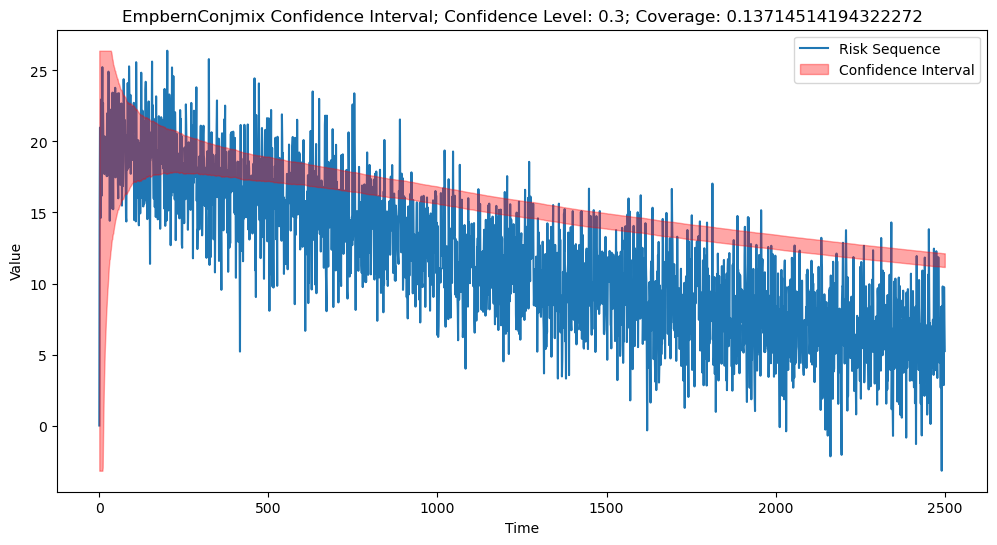

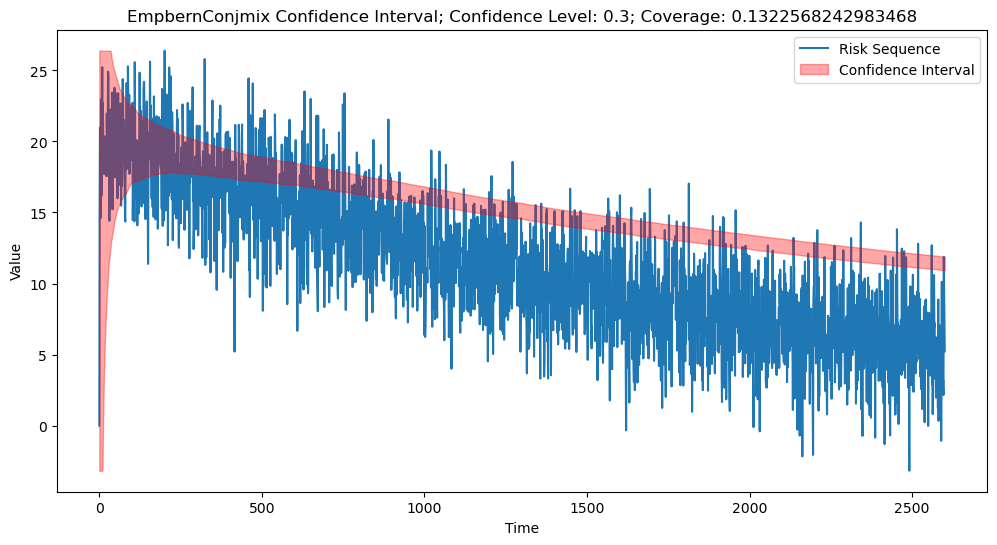

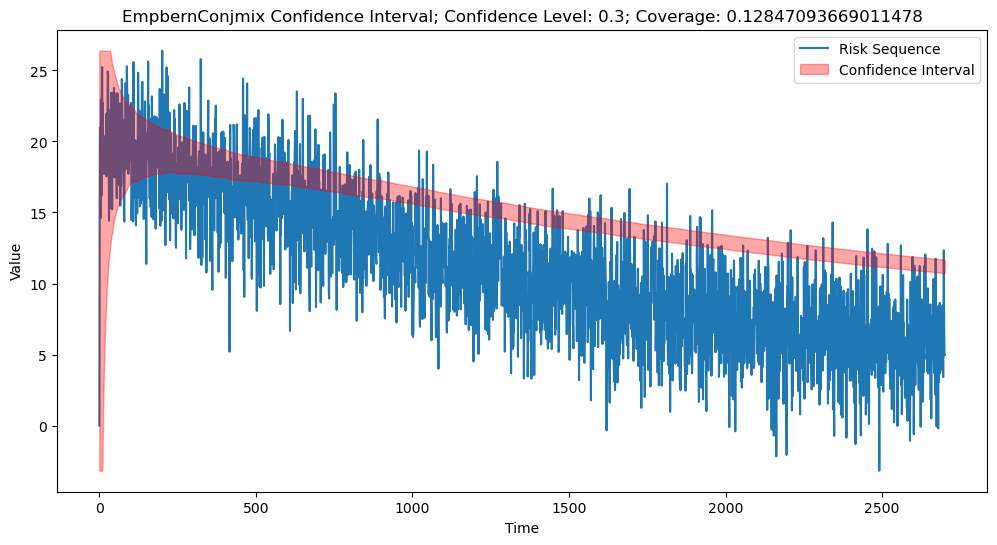

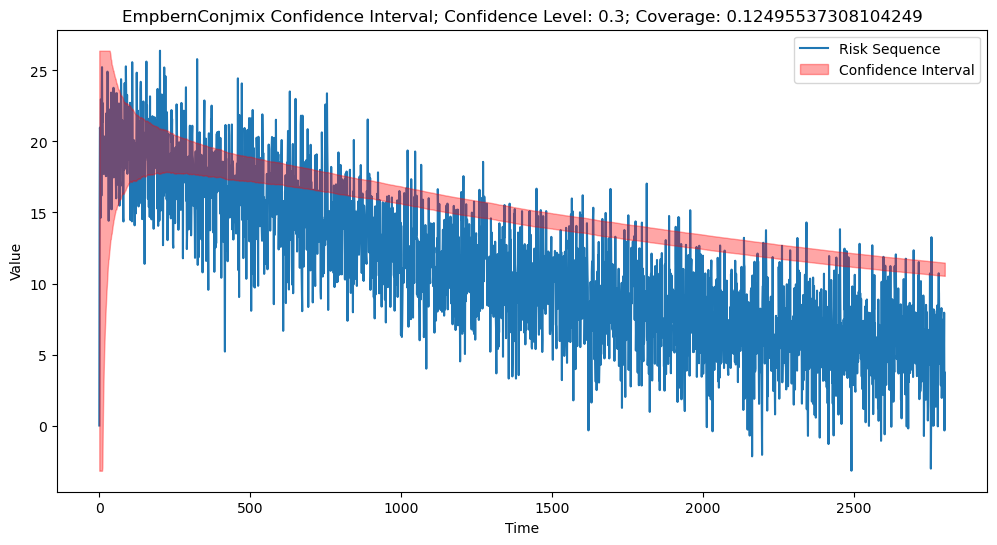

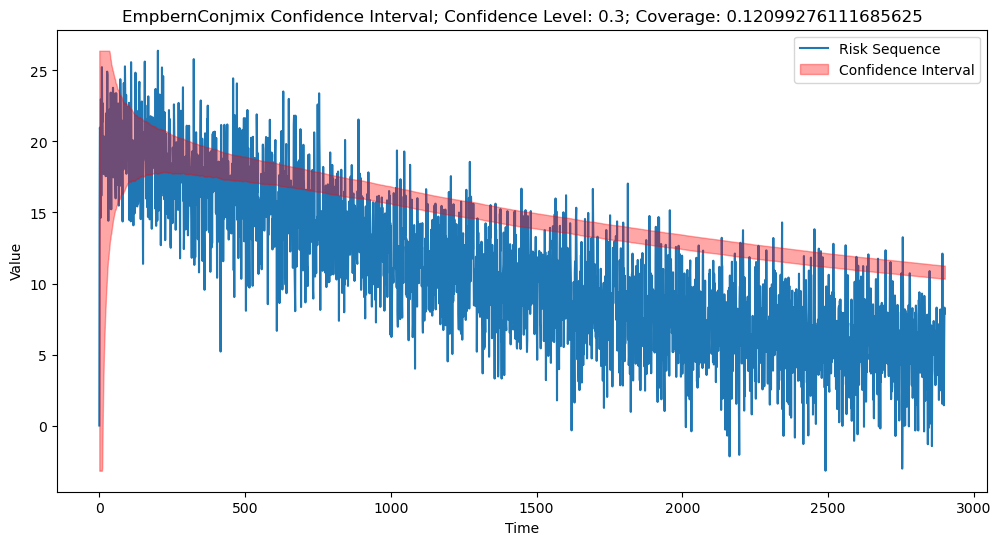

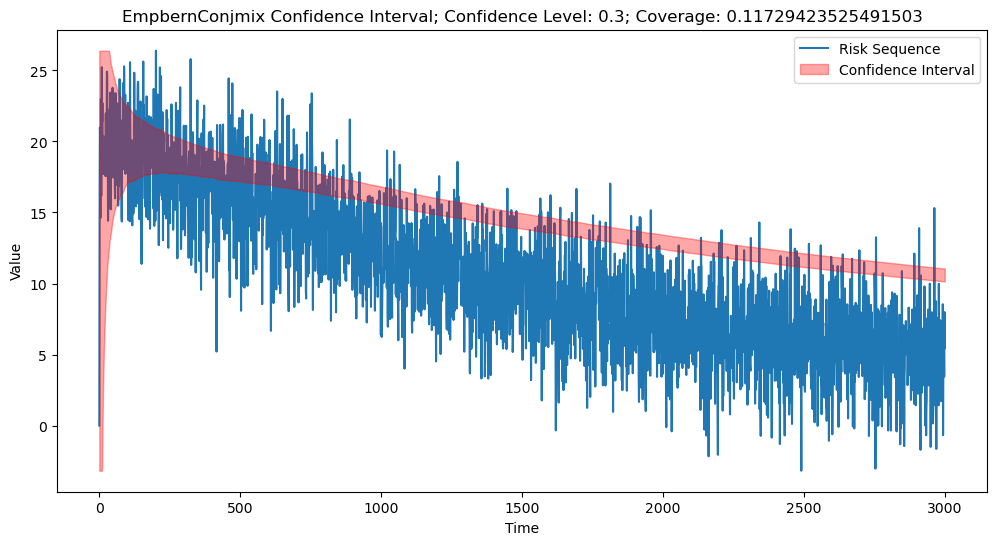

In [68]:
gamma = 0.95
mean = 20
var = 3
batch_size = 100

conf_seq = EmpbernConjmix(conf_lvl=0.3)

for i in range(30):
    data = np.random.normal(mean, var, batch_size)
    cs = conf_seq.update(data)
    conf_seq.plot()
    mean *= gamma